## Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
from sklearn import svm, datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from IPython.display import HTML
import queue

# Validate we can show an image
plt.imshow(mpimg.imread(os.path.join("test_images","test1.jpg"))) 

## HOG Feature Extraction and Classification

#### Feature Extraction

The cell below contains the functions necessary to extract HOG features and visualize them as needed

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """Function that gets HOG features and  creates a visualization if requested"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features


def extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """Function that extracts HOG features from an input set of images """
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#### Read in Images

In [3]:
# Read in cars and notcars
car_images = glob.glob(os.path.join('vehicles','*','*.png'))
notcar_images = glob.glob(os.path.join('non-vehicles','*','*.png'))
cars = []
notcars = []
for c in car_images:
    cars.append(c)
for n in notcar_images:
    notcars.append(n)

print('Total Car images: ' + str(len(cars)))
print('Total Non-Car images: ' + str(len(notcars)))

Total Car images: 8792
Total Non-Car images: 8968


#### Visualize Images

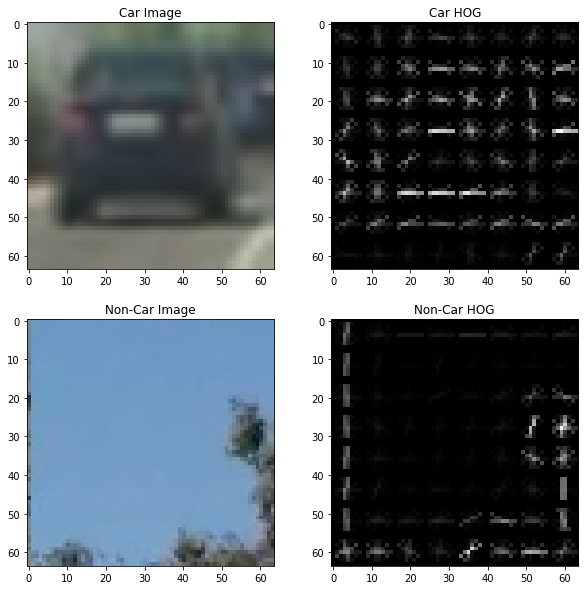

In [4]:
car_img = mpimg.imread(car_images[0])
feats, car_marked = get_hog_features(cv2.cvtColor(car_img, cv2.COLOR_RGB2HLS)[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcar_images[0])
feats, notcar_marked = get_hog_features(cv2.cvtColor(notcar_img, cv2.COLOR_RGB2HLS)[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(car_img)
ax1.set_title('Car Image')
ax2.imshow(car_marked, cmap='gray')
ax2.set_title('Car HOG')
ax3.imshow(notcar_img)
ax3.set_title('Non-Car Image')
ax4.imshow(notcar_marked, cmap='gray')
ax4.set_title('Non-Car HOG')

#### Extract Feature Sets and Train a Linear SVM Classifier

In [6]:
def extract_train_and_test_sets(cars, notcars, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """Extracts training and test sets of HOG features given a 
        set of car and not car images, and HOG paramaters"""

    car_features = extract_hog_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_hog_features(notcars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    
    return X_train, y_train, X_test, y_test, X_scaler
    
def linear_classify(X_train, y_train, X_test, y_test): 
    """Creates a linear SVM Classifierusing the input training and test sets 
        Return timing and accuracy data """
    # Train a Linear SVM Classifier
    clf = LinearSVC()
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    accuracy = clf.score(X_test, y_test)   
    
    #Return timing and accuracy
    return round(t2-t, 2), round(accuracy, 4)

#### Find Optimal Color Space and Hog Channel(s)

In initial testing, it seemed varying the color space and HOG channel had the most impact on classifier accuracy.  Thus, I setup a function that would run through a list of possible options and report all the results.

In [7]:
def optimize_color_channel(cars, notcars, color_spaces_list, hog_channel_list): 
    """Tests out a Linear SVM classifier on a combination of input 
        color spaces and HOG channels and returns a dictionary of results """
    results = {}
    for space in color_spaces_list:
        for chan in hog_channel_list:
            X_train, y_train, X_test, y_test, X_scaler = extract_train_and_test_sets(cars, notcars, 
                                                                           color_space=space, 
                                                                           hog_channel=chan)
            time, accuracy = linear_classify(X_train, y_train, X_test, y_test)
            
            identifier = space + ':' + str(chan)
            results[identifier] = accuracy
            print(identifier + ", Time=" + str(time) + " Accuracy=" + str(accuracy))
    
    return results          

In [8]:
# List of Color spaces to try
spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

# List of Channels to try
hog_channel_list = [0,1,2,"ALL"]

results = optimize_color_channel(cars, notcars, spaces, hog_channel_list)

RGB:0, Time=7.29 Accuracy=0.9378
RGB:1, Time=6.71 Accuracy=0.9561
RGB:2, Time=6.64 Accuracy=0.9468
RGB:ALL, Time=19.89 Accuracy=0.9693
HSV:0, Time=15.97 Accuracy=0.8984
HSV:1, Time=20.17 Accuracy=0.8832
HSV:2, Time=7.58 Accuracy=0.9552
HSV:ALL, Time=18.7 Accuracy=0.9834
LUV:0, Time=8.64 Accuracy=0.9406
LUV:1, Time=15.35 Accuracy=0.9206
LUV:2, Time=18.88 Accuracy=0.8868
LUV:ALL, Time=17.73 Accuracy=0.9803
HLS:0, Time=17.22 Accuracy=0.902
HLS:1, Time=7.5 Accuracy=0.9541
HLS:2, Time=23.65 Accuracy=0.8784
HLS:ALL, Time=17.09 Accuracy=0.9806
YUV:0, Time=7.65 Accuracy=0.9465
YUV:1, Time=13.82 Accuracy=0.9169
YUV:2, Time=19.88 Accuracy=0.8986
YUV:ALL, Time=4.54 Accuracy=0.98
YCrCb:0, Time=7.2 Accuracy=0.9454
YCrCb:1, Time=14.79 Accuracy=0.915
YCrCb:2, Time=18.29 Accuracy=0.8998
YCrCb:ALL, Time=15.44 Accuracy=0.9823


In [10]:
print("Color Space: HOG Channel | Accuracy")
print("========================================")   
for i in keys:           
    print("     %-9s           | %2.2f" % (i,results[i]*100)  + "%")       
print("========================================")

Color Space: HOG Channel | Accuracy
     HLS:0               | 90.20%
     HLS:1               | 95.41%
     HLS:2               | 87.84%
     HLS:ALL             | 98.06%
     HSV:0               | 89.84%
     HSV:1               | 88.32%
     HSV:2               | 95.52%
     HSV:ALL             | 98.34%
     LUV:0               | 94.06%
     LUV:1               | 92.06%
     LUV:2               | 88.68%
     LUV:ALL             | 98.03%
     RGB:0               | 93.78%
     RGB:1               | 95.61%
     RGB:2               | 94.68%
     RGB:ALL             | 96.93%
     YCrCb:0             | 94.54%
     YCrCb:1             | 91.50%
     YCrCb:2             | 89.98%
     YCrCb:ALL           | 98.23%
     YUV:0               | 94.65%
     YUV:1               | 91.69%
     YUV:2               | 89.86%
     YUV:ALL             | 98.00%


#### Training the final classifier

Using the information from the above experiments, I create the final classifier using a GridSearchCV to tune the 'kernel' and 'C' paramaters 

In [11]:
chosen_cspace='YUV'
chosen_hog_chan = 0

In [12]:
# Extract features using chosen color space and HOG channel
X_train, y_train, X_test, y_test, X_scaler = extract_train_and_test_sets(cars, notcars, 
                                                                         color_space=chosen_cspace,
                                                                         hog_channel=chosen_hog_chan)

In [ ]:
# Init classifier with tuned params
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)

# Train Classifier
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifier and chose params...')
# Check the score of the SVC
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
print('Best params: ', clf.best_params_)

#### Checkpoint: Store the classifier

Store the Classifier at this point, so I don't have to retrain it each time I use this notebook

In [290]:
# Checkpoint.  Store data
data = {
    'clf': clf,
    'X_scaler': X_scaler
}
with open('clf_data.p', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

## Sliding Windows

#### Gather varied test images

Gather some test images from project video with cars at different distances

In [4]:
from moviepy.editor import VideoFileClip
# Test the pipeline on a single frame of the project video to verify it works all together
clip = VideoFileClip("project_video.mp4")

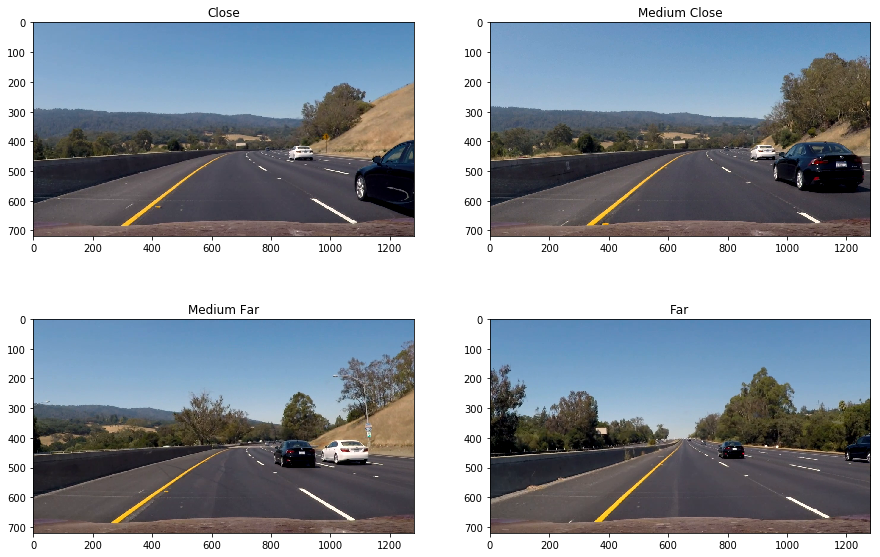

In [5]:
image_close = clip.get_frame(28)
image_mid_close = clip.get_frame(30)
image_mid_far = clip.get_frame(37)
image_far = clip.get_frame(50)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(image_close)
ax1.set_title('Close')
ax2.imshow(image_mid_close)
ax2.set_title('Medium Close')
ax3.imshow(image_mid_far)
ax3.set_title('Medium Far')
ax4.imshow(image_far)
ax4.set_title('Far')

#### Configure sliding window pipeline

Setup a function to determine the best box sizes for each area 

In [6]:
def draw_boxes(img, ystart, ystop, scale, pix_per_cell=8, cell_per_block=2):
    """Function to draw a set of bounding boxes at a given scale"""
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    
    cv2.rectangle(draw_img,(0,ystart), (draw_img.shape[1],ystop),(0,0,255),9) 

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    cells_per_step = 8  # Instead of overlap, define how many cells to step.  Use 8 for the example
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
   
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
            cv2.rectangle(draw_img,rect[0], rect[1],(255,0,0),3) 
                
    return draw_img


Apply search sizes and regions to images to tune window sizes

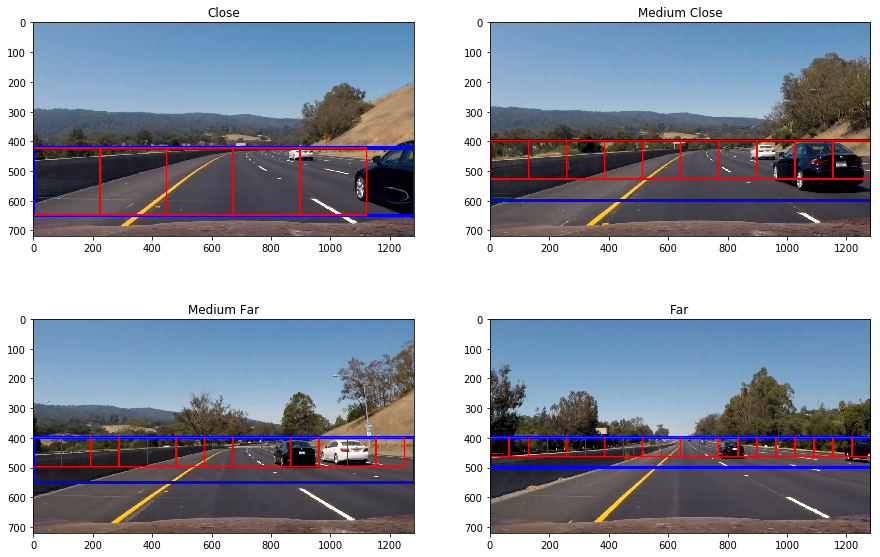

In [7]:
image_close_marked = draw_boxes(image_close, 425, 650, 3.5)
image_mid_close_marked = draw_boxes(image_mid_close, 400, 600, 2)
image_mid_far_marked = draw_boxes(image_mid_far, 400, 550, 1.5)
image_far_marked = draw_boxes(image_far, 400, 500, 1)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(image_close_marked)
ax1.set_title('Close')
ax2.imshow(image_mid_close_marked)
ax2.set_title('Medium Close')
ax3.imshow(image_mid_far_marked)
ax3.set_title('Medium Far')
ax4.imshow(image_far_marked)
ax4.set_title('Far')

Setup a function to find cars using sliding window and HOG features 

In [8]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9, pix_per_cell=8, 
              cell_per_block=2, cspace=chosen_cspace, hog_channel=chosen_hog_chan):
    """Extract features using HOG sub-sampling and make predictions using the given classifier"""
    cars_boxes = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                test_features = X_scaler.transform(np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1))   
            else:
                test_features = X_scaler.transform(hog_feat1.reshape(1, -1))  

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rect = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cars_boxes.append(rect)
    
    return cars_boxes

def sliding_window_pipe(img, svc, X_scaler):
    """Applys several sliding window passes of different sizes to a given image and returns all found windows"""
    hot_windows_close = find_cars(img, 425, 650, 3.5, svc, X_scaler)
    hot_windows_mid_close = find_cars(img, 400, 600, 2, svc, X_scaler) 
    hot_windows_mid_far = find_cars(img,  400, 550, 1.5, svc, X_scaler)
    hot_windows_far = find_cars(img, 400, 500, 1, svc, X_scaler)
    return hot_windows_close+hot_windows_mid_close+hot_windows_mid_far+hot_windows_far

def draw_boxes_on_image(img, rects):
    """Draws an input set of rectangles on an image"""
    result = np.copy(img)
    for rect in rects:
        cv2.rectangle(result,rect[0], rect[1],(0,0,255),4) 
    return result

#### Test On image

In [9]:
# load a pe-trained svc model 
dist_pickle = pickle.load( open("clf_data.p", "rb" ) )

# get attributes of our clf object
clf = dist_pickle["clf"]
X_scaler = dist_pickle["X_scaler"]

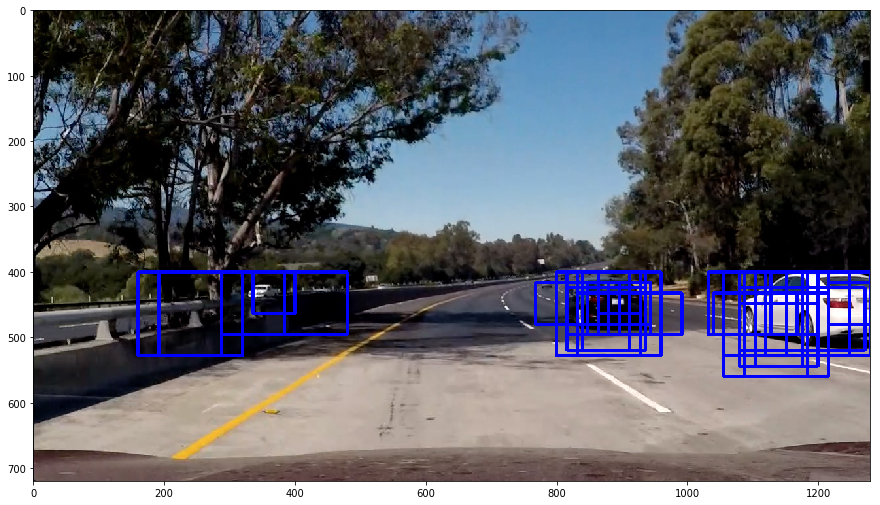

In [10]:
# Test the window pipeline on a test image
test_img = mpimg.imread(os.path.join("test_images","test5.jpg")) 
car_windows = sliding_window_pipe(test_img, clf, X_scaler)

# Draw the windows on the image
windows_image = draw_boxes_on_image(test_img, car_windows)
plt.figure(figsize=(15,15))
plt.imshow(windows_image)

## Heat Map

In [11]:
from scipy.ndimage.measurements import label

def create_heat_map(img, box_list, threshold=1):
    """Creates a heatmap from a list of given boxes, and applys the 
       labeled heatmap to a given input image to draw bounding boxes"""
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1   
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap, 0, 255)
    
    labels = label(heatmap)
       
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        
    return bboxes, heatmap

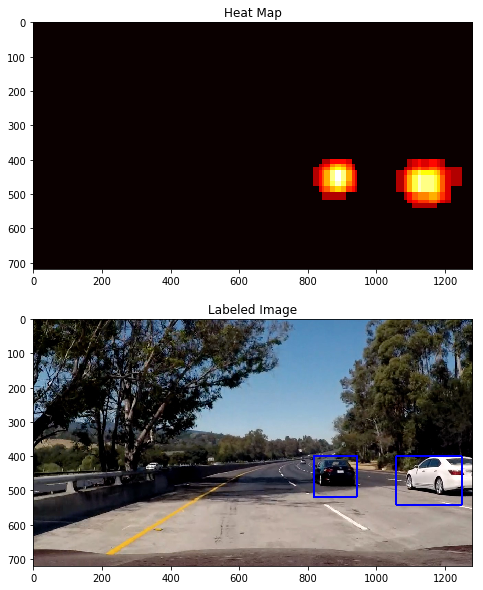

In [12]:
bboxes, heatmap = create_heat_map(test_img, car_windows, threshold=3)

f, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15,10))
ax1.imshow(heatmap, cmap='hot')
ax1.set_title('Heat Map')
ax2.imshow(draw_boxes_on_image(test_img, bboxes))
ax2.set_title('Labeled Image')

## Combined Pipeline

Combine all the previous steps into a processing pipe that can be used with the moviepy video processing.

In [13]:
def process_image(image):
    """Detects vehicles on a given image and adds a bounding box around each one"""    
    
    # Find bounding boxes
    car_windows = sliding_window_pipe(image, clf, X_scaler)
    full_detections = draw_boxes_on_image(image, car_windows)
    
    #Create heatmap and apply to image
    bboxes, heatmap = create_heat_map(image, car_windows, threshold=3)
    
    # Draw bounding boxes
    result = draw_boxes_on_image(image, bboxes)
    
    # Add composities of heatmap and sliding window images
    full_detections_small = cv2.resize(full_detections, (int(full_detections.shape[1]/4),int(full_detections.shape[0]/4)))
    heatmap_small = cv2.resize(heatmap, (int(heatmap.shape[1]/4),int(heatmap.shape[0]/4)))
    color_heatmap = np.dstack(( heatmap_small, heatmap_small, heatmap_small)) * 255
    
    result[:full_detections_small.shape[0],-full_detections_small.shape[1]:,:] = full_detections_small
    result[:color_heatmap.shape[0],-color_heatmap.shape[1]-full_detections_small.shape[1]:-full_detections_small.shape[1],:] = color_heatmap
    
    # Add detection text    
    cv2.putText(result,"Total Cars Detected: %d" % len(bboxes), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        
    return result

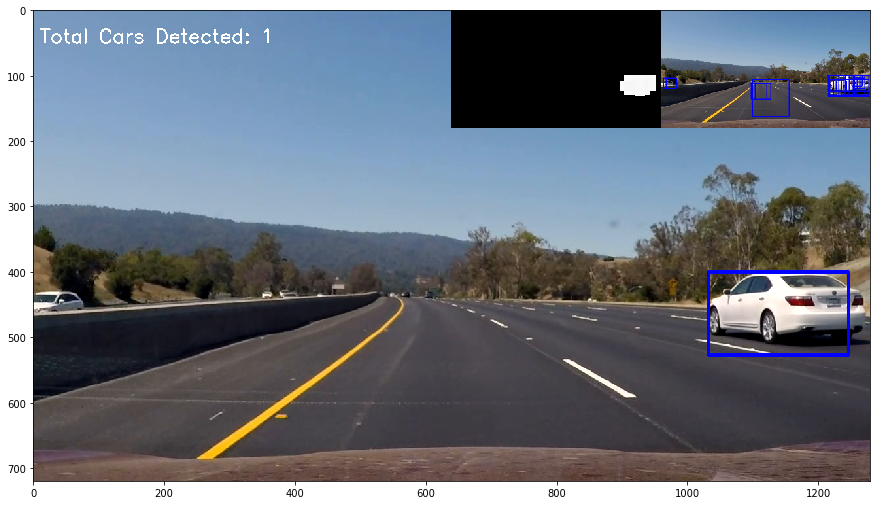

In [18]:
# Test the pipeline on a single frame of the project video to verify it works all together
clip = VideoFileClip("project_video.mp4")
plt.figure(figsize=(15,15))
plt.imshow(process_image(clip.get_frame(10)))
clip.reader.close()
clip.audio.reader.close_proc()

### Test pipeline on project video

Apply the above pipeline to the project video.

In [20]:
# Process the project video using the pipeline
output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
proc_clip = clip1.fl_image(process_image) 
%time proc_clip.write_videofile(output, audio=False)

# Close the video to avoid open handles
clip1.reader.close()
clip1.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:36<00:04,  4.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 2min 37s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

Apply the above pipeline to the project video.

In [21]:
output2 = 'project_video_out.mp4'
clip2 = VideoFileClip("project_video.mp4")
proc_clip2 = clip2.fl_image(process_image) 
%time proc_clip2.write_videofile(output2, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [47:24<00:02,  2.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 47min 25s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

## Improved Pipeline

In [21]:
# Size of history
size_of_history = 10

# global lane lines
boxes_q = queue.Queue(maxsize=size_of_history)

def resetPipe():
    """Reset Pipeline"""
    global boxes_q    
    boxes_q = queue.Queue(maxsize=size_of_history)

def process_image_improved(image):
    """Combine all previous steps into a single image processing pipe to be used to process videos"""    
    
    global boxes_q 
    
    # Find bounding boxes
    car_windows = sliding_window_pipe(image, clf, X_scaler)
    full_detections = draw_boxes_on_image(image, car_windows)
    
    #Create heatmap and apply to image
    bboxes_frame, heatmap = create_heat_map(image, car_windows, threshold=2)
        
    if boxes_q.full():
        boxes_q.get()
    
    if len(car_windows) > 0:
        boxes_q.put(bboxes_frame) 
    
    # Calculate full array and threshold based on amount of previous boxes
    frame_history = boxes_q.qsize()
    threshold = frame_history - 1
    bboxes_full_array = []
    for frame in list(boxes_q.queue):
        bboxes_full_array += frame
        
    #Create heatmap and apply to image
    bboxes, heatmap_combo = create_heat_map(image, bboxes_full_array, threshold=threshold)
    
    # Draw bounding boxes
    result = draw_boxes_on_image(image, bboxes)
    
    # Add composities of heatmap and sliding window images
    full_detections_small = cv2.resize(full_detections, (int(full_detections.shape[1]/4),int(full_detections.shape[0]/4)))
    heatmap_small = cv2.resize(heatmap, (int(heatmap.shape[1]/4),int(heatmap.shape[0]/4)))
    color_heatmap = np.dstack(( heatmap_small, heatmap_small, heatmap_small)) * 255
    
    result[:full_detections_small.shape[0],-full_detections_small.shape[1]:,:] = full_detections_small
    result[:color_heatmap.shape[0],-color_heatmap.shape[1]-full_detections_small.shape[1]:-full_detections_small.shape[1],:] = color_heatmap
    
    # Add detection text    
    cv2.putText(result,"Total Cars Detected: %d" % len(bboxes), (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255,255,255), 2)
        
    return result

In [22]:
resetPipe()

output3 = 'test_video_out_improved.mp4'
clip3 = VideoFileClip("test_video.mp4")
proc_clip3 = clip3.fl_image(process_image_improved) 
%time proc_clip3.write_videofile(output3, audio=False)
clip3.reader.close()
clip3.audio.reader.close_proc()

[MoviePy] >>>> Building video test_video_out_improved.mp4
[MoviePy] Writing video test_video_out_improved.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:20<00:03,  3.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_improved.mp4 

Wall time: 2min 21s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))

In [24]:
resetPipe()
output4 = 'project_video_out_improved.mp4'
clip4 = VideoFileClip("project_video.mp4")
proc_clip4 = clip4.fl_image(process_image) 
%time proc_clip4.write_videofile(output4, audio=False)
clip4.reader.close()
clip4.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_out_improved.mp4
[MoviePy] Writing video project_video_out_improved.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:11:18<00:03,  3.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_improved.mp4 

Wall time: 1h 11min 18s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output4))